In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Documents/eth_courses/notebooks/dynamics/julia/demos/quad_2d`


In [2]:
# Pkg.add("Revise");

In [65]:
using Revise
using ModelingToolkit, LinearAlgebra
using GLMakie
using ControlSystems
using DifferentialEquations
# using Plots

include("utilities.jl")
include("types.jl")

SafetyBox2

## Utilities 

In [66]:
# 2D rotation matrix
R_2D(θ::Float64) = [cos(θ) -sin(θ); sin(θ) cos(θ)];

## Dynamics using DifferentialEquationsjl

In [67]:
motor_left = BLDCMotor(0, 12.5)
motor_right = BLDCMotor(0, 12.5)

quad_obj = Quad2d(1.0, 0.1, 0.003, motor_left, motor_right)
sim_params = SimParams(6, 0.01) 
safety_box = SafetyBox(10, 10, 10, -10, -10, 0)

SafetyBox2(10.0, 10.0, 10.0, -10.0, -10.0, 0.0)

In [102]:
#Define the problem
function quad_2d(dx, X, params, t)

    m, g, l, I_xx = params
    g_vec = [0;g]
    
    # get the state
    y = X[1]
    z = X[2]
    θ = X[3]
    ẏ = X[4]
    ż = X[5]
    θ̇ = X[6]

    # get the control input
    f_1 = X[7]
    f_2 = X[8]

    # compute control action
    f_thrust = f_1 + f_2
    a_thrust = (f_thrust / m) # mass normalized thrust 
    
    τ = (f_1 - f_2) * l

    # translation E.O.M
    f = [0; a_thrust]
    (ÿ, z̈) = R_2D(θ)*f + g_vec 

    # rotational E.O.M
    θ̈ = τ / I_xx
    
    dx[1], dx[2], dx[3] = ẏ, ż, θ̇
    dx[4], dx[5], dx[6] = ÿ, z̈, θ̈
end

quad_2d (generic function with 1 method)

In [103]:
# run at every timestep
condition(u,t,integrator) = true

function affect!(integrator)

     # Extract the parameters
    (; m, g, l, I_xx, safety_box) = params
    
     # Extract the state 
    X = integrator.u[1:sim_params.nx] 

    y::Float64 = X[1]
    z::Float64 = X[2]
    θ::Float64 = X[3]
    ẏ::Float64 = X[4]
    ż::Float64 = X[5]
    θ̇::Float64 = X[6]

    # Limit operating space 
    if z > safety_box.z_max
        z = clamp(z, safety_box.z_min, safety_box.z_max)
        ż = 0
        println("Z operational space constraint violated !")
        terminate!(integrator)

    elseif z < safety_box.z_min
        z = clamp(z, safety_box.z_min, safety_box.z_max)
        ż = 0
        println("Landed !")
        terminate!(integrator)
    end

    if y < safety_box.y_min || y > safety_box.y_max
        y = clamp(y, safety_box.y_min, safety_box.y_max)
        ẏ = 0
        println("Y operational space constraint violated !")
        terminate!(integrator)
    end

end

cb = DiscreteCallback(condition,affect!)

DiscreteCallback{typeof(condition), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

Landed !


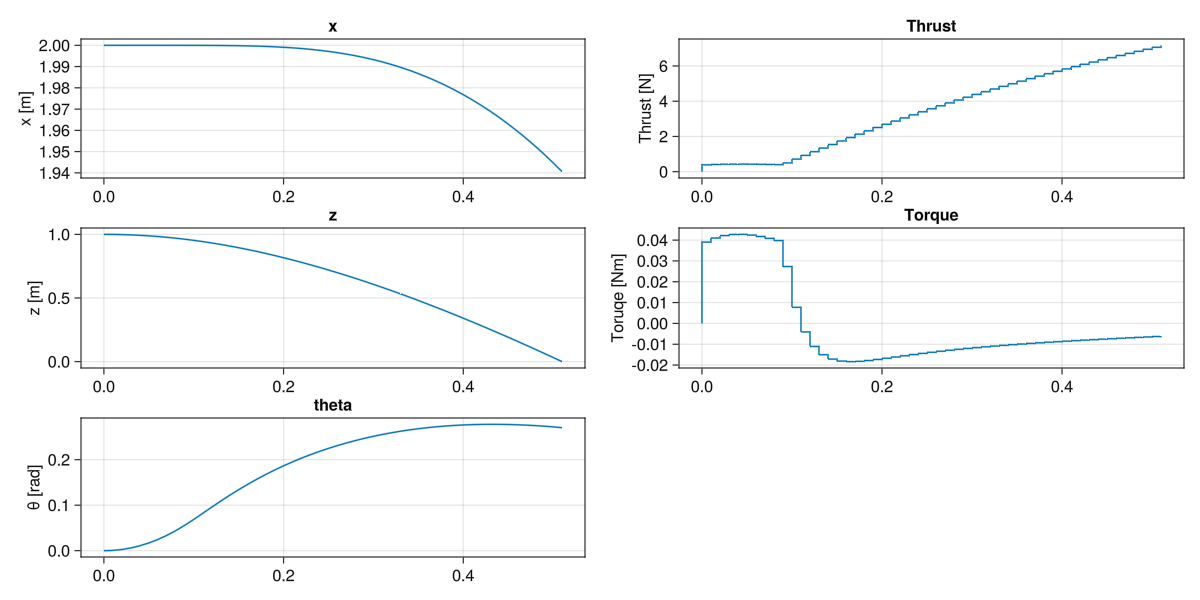

In [105]:
control_cb = PeriodicCallback(sim_params.Ts, initial_affect=true) do integrator
    p = integrator.p    # Extract the parameter object from the integrator
    nx = 6
    
    # Extract the parameters
    (; m, g, l, I_xx, safety_box) = params

    # Extract the state 
    X = integrator.u[1:sim_params.nx] 

    # compute control input
    U = - K * X

    f_1 = U[1]
    f_2 = U[2]

    # constrain the control input
    f_1 = clamp(f_1, quad_obj.motor_left.thrust_min, quad_obj.motor_left.thrust_max)
    f_2 = clamp(f_2, quad_obj.motor_right.thrust_min, quad_obj.motor_right.thrust_max)

    # println("Control: $(U)")
    
    #Update the control-signal
    integrator.u[nx+1:end] .= [f_1, f_2]
end

# parameters
params = (; m=quad_obj.m, g=-9.81, l=quad_obj.L, I_xx = 0.003, safety_box = safety_box)

#Initial Conditions
x₀ = Pose2D(2,1,0,0,0,0)

tspan = (0.0, 10.0);

initial_state = [x₀.y, x₀.z, x₀.θ, x₀.ẏ, x₀.ż, x₀.θ̇]; # state
u₀ = [0,0]; # control

initial_conditions = vcat(initial_state,u₀)

#Pass to solvers
cb_set = CallbackSet(control_cb,cb)
prob = ODEProblem(quad_2d, initial_conditions, tspan, params, callback=cb_set);
sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8);

quad_2d_plot_normal(sol)

## Continuous time control

In [49]:
# # parameters [m, g, l, I_xx]
# params = [1.0, -9.81, 0.1, 0.003]

# #Initial Conditions
# u₀ = [2,1,0,0,0,0];
# tspan = (0.0, 10.0);

# #Pass to solvers
# prob = ODEProblem(quad_2d, u₀, tspan, params);
# sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8);

# quad_2d_plot_normal(sol)

## Dynamics using ModellingToolkit

In [8]:
function quad_dynamics_mtk()
    # define parameters and variables
    @parameters l, I_xx, m
    
    # state variables
    @variables t, y(t), z(t), θ(t)
    
    # control input
    # @variables f_1(t)=9.81/2 [input=true] f_2(t)=9.81/2 [input=true]
    @variables f_1(t)=0 [input=true] f_2(t)=0 [input=true]
    
    @constants g=-9.81 
    
    # define operators
    D = Differential(t)

    f_thrust = f_1 + f_2
    a_thrust = (f_thrust / m) # mass normalized thrust 
    
    τ = (f_1 - f_2) * l
    
    # dynamics equations
    
    # gravity 
    g_vec = [0;g]
    
    # create custom rotation matrix
    R_2D(θ::Real) = [cos(θ) -sin(θ); sin(θ) cos(θ)];
    
    # translation E.O.M
    f = [0; a_thrust]
    (ÿ, z̈) = R_2D(θ)*f + g_vec 

    # rotational E.O.M
    θ̈ = τ / I_xx
    
    eqs = [
        # D(f_1) ~ 0,
        # D(f_2) ~ 0,
        D(D(y)) ~ ÿ,
        D(D(z)) ~ z̈,
        D(D(θ)) ~ θ̈]
    
    # create ODESystem and simplify
    @named sys_unsimplified = ODESystem(eqs)
    sys = structural_simplify(sys_unsimplified );

    # Linearization
    
    return sys, sys_unsimplified
end

sys, sys_unsimplified  =  quad_dynamics_mtk();

# Linearization

In [9]:
function convert_to_numeric(A::Array{Num})
    A_num = [i.val for i in A]
    A_num = convert(Array{Float64}, A_num)
    
    return A_num
end

function linearize_system(Ts::Float64)
    # ================= Copy pasted , don't modify ! ========================
        
    # define parameters and variables
        @parameters l, I_xx, m
        
        # state variables
        @variables t, y(t), z(t), θ(t)
        
        # control input
        @variables f_1(t)=0 [input=true] f_2(t)=0 [input=true] 
        
        @constants g=-9.81 
        
        # define operators
        D = Differential(t)
    # ==================================================================== 
        
    nonlinear_eq_vec = [D(y),
                        D(z), 
                        D(θ), 
                        equations(sys_unsimplified)[1].rhs,
                        equations(sys_unsimplified)[2].rhs,
                        equations(sys_unsimplified)[3].rhs]
    
    state_vec = [y, z, θ, D(y), D(z), D(θ)]
    control_vec = [f_1, f_2]
    
    # Calculate A,B matrices
    A = Symbolics.jacobian(nonlinear_eq_vec, state_vec)
    B = Symbolics.jacobian(nonlinear_eq_vec, control_vec)

    AB_symbolic = [A,B]
    
    
    # Linearize around equilibrium point
    
    x₀ = Dict(
        y => 0.0,
        θ => 0.0,
        z => 0.0,
        D(y) => 0.0,
        D(θ) => 0.0,
        D(z) => 0.0,   
    )
    
    thrust_eq::Float64 = 9.81;
        
    u₀ = Dict(
        f_1 => thrust_eq/2,
        f_2 => thrust_eq/2
    )
    
    A = substitute(A, u₀);
    A = substitute(A, x₀);
    B = substitute(B, u₀);
    B = substitute(B, x₀);

    # parameter values
    params = Dict(
        l => 0.1,
        I_xx => 0.003 ,
        m => 1.0,
    )

    # Assume y,z positon and angular velocity is measured
    C = [1 1 0 0 0 1];
    D = 0;

    matrices_symbolic = [A,B,C,D]
    
    # Substitute parameters
    A = substitute(A, params)
    B = substitute(B, params)

    A = convert_to_numeric(A)
    B = convert_to_numeric(B)
    
     # create continuous time system 
    sys_c = ss(A, B, C, 0)
    
    # create discrete time system 
    # sys_d = ss(A, B, C, 0, Ts)
    sys_d = c2d(sys_c, Ts)

    return sys_c, sys_d, matrices_symbolic

end

linearize_system (generic function with 1 method)

In [10]:
# sim_params = SimParams(length(states(sys)), 0.01) 

sys_c, sys_d, AB_symbolic = linearize_system(sim_params.Ts)

(StateSpace{Continuous, Float64}
A = 
 0.0  0.0   0.0   1.0  0.0  0.0
 0.0  0.0   0.0   0.0  1.0  0.0
 0.0  0.0   0.0   0.0  0.0  1.0
 0.0  0.0  -9.81  0.0  0.0  0.0
 0.0  0.0   0.0   0.0  0.0  0.0
 0.0  0.0   0.0   0.0  0.0  0.0
B = 
  0.0                  0.0
  0.0                  0.0
  0.0                  0.0
  0.0                  0.0
  1.0                  1.0
 33.333333333333336  -33.333333333333336
C = 
 1.0  1.0  0.0  0.0  0.0  1.0
D = 
 0.0  0.0

Continuous-time state-space model, StateSpace{Discrete{Float64}, Float64}
A = 
 1.0  0.0  -0.0004905  0.01  0.0   -1.6350000000000007e-6
 0.0  1.0   0.0        0.0   0.01   0.0
 0.0  0.0   1.0        0.0   0.0    0.01
 0.0  0.0  -0.0981     1.0   0.0   -0.0004905
 0.0  0.0   0.0        0.0   1.0    0.0
 0.0  0.0   0.0        0.0   0.0    1.0
B = 
 -1.3625000000000005e-7   1.3625000000000005e-7
  5.0000000000000016e-5   5.0000000000000016e-5
  0.0016666666666666672  -0.0016666666666666672
 -5.4500000000000024e-5   5.4500000000000024e

# LQR Controller

### Design controller

In [11]:
Q       = Diagonal([1,1,1,1,1,1]) # Weighting matrix for state
R       = Diagonal([1,1]) # Weighting matrix for input

# Compute LQR gain matrix
K      = lqr(sys_d,Q,R) 

2×6 Matrix{Float64}:
 -0.544864  0.69938   3.16405  -0.805202  1.09019   0.625058
  0.544864  0.69938  -3.16405   0.805202  1.09019  -0.625058

In [12]:
# Compute LQR gain matrix
K_c      = lqr(sys_c,Q,R) 

2×6 Matrix{Float64}:
 -0.707107  0.707107   4.04884  -1.041  1.09868   0.788331
  0.707107  0.707107  -4.04884   1.041  1.09868  -0.788331

## Discrete-time Linear Simulation

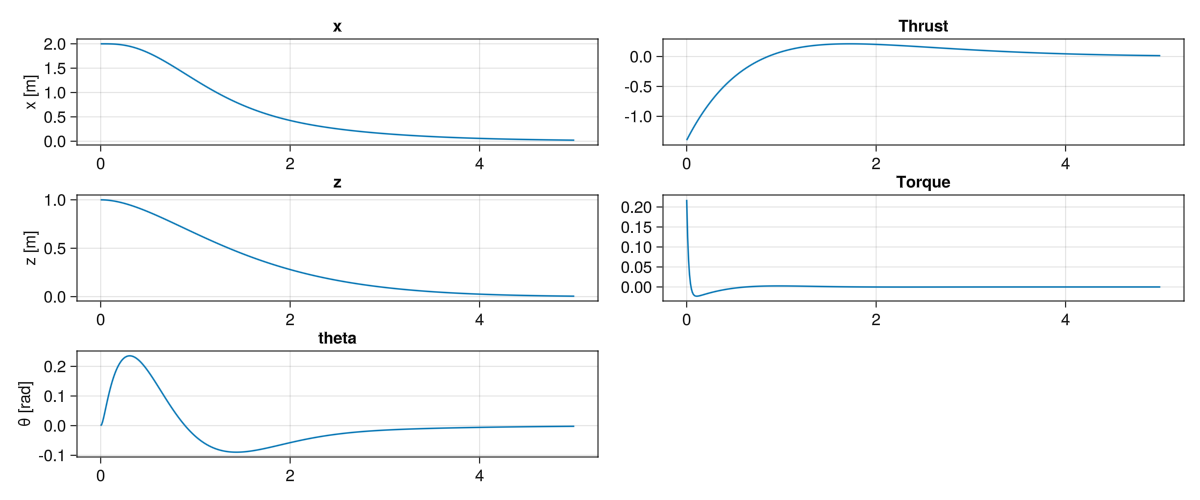

In [13]:
# Simulation
u_l(x,t)  = -K*x 
t       = 0:sim_params.Ts:5              # Time vector
x0      = [2,1,0,0,0,0]               # Initial condition

y, t, x, uout = lsim(sys_d,u_l,t,x0=x0)

quad_2d_plot_lsim(t,x)

## Continuous-time Linear Simulation

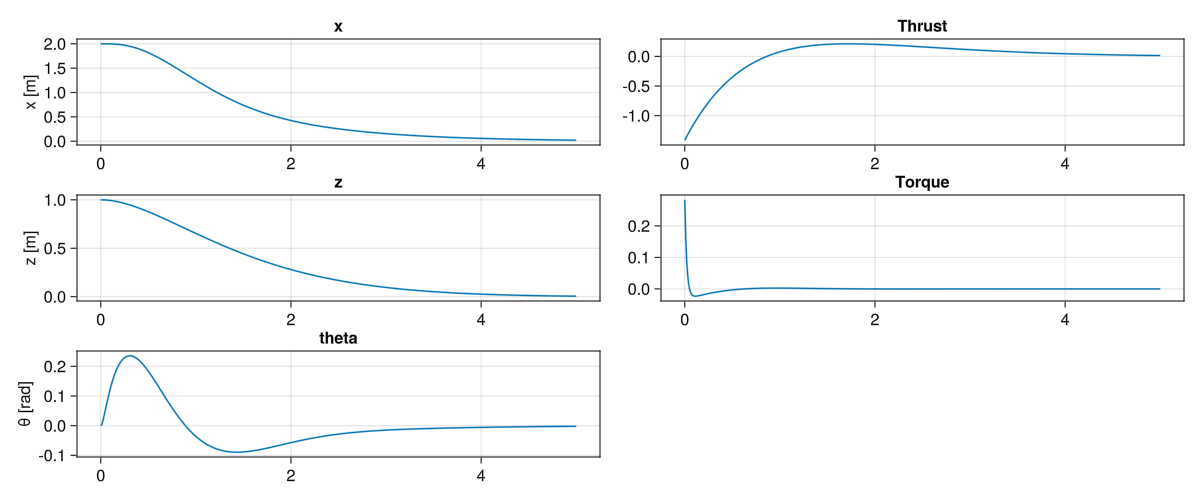

In [14]:
# Simulation
u_l(x,t)  = -K_c*x 
t       = 0:sim_params.Ts:5              # Time vector
x0      = [2,1,0,0,0,0]               # Initial condition

y, t, x, uout = lsim(sys_c,u_l,t,x0=x0)

quad_2d_plot_lsim(t,x)

In [15]:
uout[:,1:10]

2×10 Matrix{Float64}:
  0.707107   0.130789  -0.22169  …  -0.686746  -0.690675  -0.686591
 -2.12132   -1.51417   -1.13133     -0.521421  -0.489867  -0.466762

## Nonlinear Simulation

In [16]:
function quad_dynamics_mtk()
    # define parameters and variables
    @parameters l, I_xx, m
    
    # state variables
    @variables t, y(t), z(t), θ(t)
    
    # control input
    @variables f_1(t)=0 f_2(t)=0
    # @variables f_1(t)=0 [input=true] f_2(t)=0 [input=true]
    
    @constants g=-9.81 
    
    # define operators
    D = Differential(t)

    f_thrust = f_1 + f_2
    a_thrust = (f_thrust / m) # mass normalized thrust 
    
    τ = (f_1 - f_2) * l
    
    # gravity 
    g_vec = [0;g]
    
    # create custom rotation matrix
    R_2D(θ::Real) = [cos(θ) -sin(θ); sin(θ) cos(θ)];
    
    # translation E.O.M
    f = [0; a_thrust]
    (ÿ, z̈) = R_2D(θ)*f + g_vec 

    # rotational E.O.M
    θ̈ = τ / I_xx
    
    eqs = [
        D(f_1) ~ 0,
        D(f_2) ~ 0,
        D(D(y)) ~ ÿ,
        D(D(z)) ~ z̈,
        D(D(θ)) ~ θ̈]
    
    # create ODESystem and simplify
    @named sys_unsimplified = ODESystem(eqs)
    sys = structural_simplify(sys_unsimplified );

    # Linearization
    

    return sys, sys_unsimplified
end

sys, sys_unsimplified  =  quad_dynamics_mtk();

In [17]:
cb1 = PeriodicCallback(sim_params.Ts,initial_affect=true) do integrator

    t = integrator.t # timestep  

    X::Array{Float64} = integrator.u[3:sim_params.nx+2] # Extract the state 
    # U::Array{Float64} = integrator.u[1:2] # Extract the control signal
    # println("Timestep: $(t)")
    
    ẏ::Float64 = X[1]
    ż::Float64 = X[2]
    θ̇::Float64 = X[3]
    y::Float64 = X[4]
    z::Float64 = X[5]
    θ::Float64 = X[6]

    # # rearrange state vector to apply LQR
    X_new::Array{Float64} = [y,z,θ,ẏ,ż,θ̇]

    # compute control actions 
    u = -K * X_new

     # set the control input
    f_1 = u[1]
    f_2 = u[2]

    # constrain the control input
    f_max::Float64 = 12.5 # N
    f_min::Float64 = 5 # N
    
    # f_1 = clamp(f_1, f_min, f_max)
    # f_2 = clamp(f_2, f_min, f_max)

    # f_1 = 9.81/2
    # f_2 = 9.81/2
    
    # println("Control $(t) : ", u)
    
    # update the state 
     integrator.u[1:2] = [f_1,f_2]
    
    params = integrator.p

    # integrator.p[4] = f_1
    # integrator.p[5] = f_2
    
    # println("Parameters $(t) : ", params)
    # println("Timestep: $(t)")
    # println("State: $(X)")
end

DiscreteCallback{DiffEqCallbacks.var"#44#48"{Bool, Float64, Base.RefValue{Int64}, Base.RefValue{Float64}}, DiffEqCallbacks.PeriodicCallbackAffect{var"#9#10", Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, DiffEqCallbacks.var"#45#49"{Bool, DiffEqCallbacks.var"#47#51"{Bool}, Float64, DiffEqCallbacks.PeriodicCallbackAffect{var"#9#10", Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}}, typeof(SciMLBase.FINALIZE_DEFAULT)}(DiffEqCallbacks.var"#44#48"{Bool, Float64, Base.RefValue{Int64}, Base.RefValue{Float64}}(false, 0.01, Base.RefValue{Int64}(0), Base.RefValue{Float64}(Inf)), DiffEqCallbacks.PeriodicCallbackAffect{var"#9#10", Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}(var"#9#10"(), 0.01, Base.RefValue{Float64}(Inf), Base.RefValue{Int64}(0)), DiffEqCallbacks.var"#45#49"{Bool, DiffEqCallbacks.var"#47#51"{Bool}, Float64, DiffEqCallbacks.PeriodicCallbackAffect{var"#9#10", Float64, Base.RefValue{Float64}, Base.RefValue{Int6

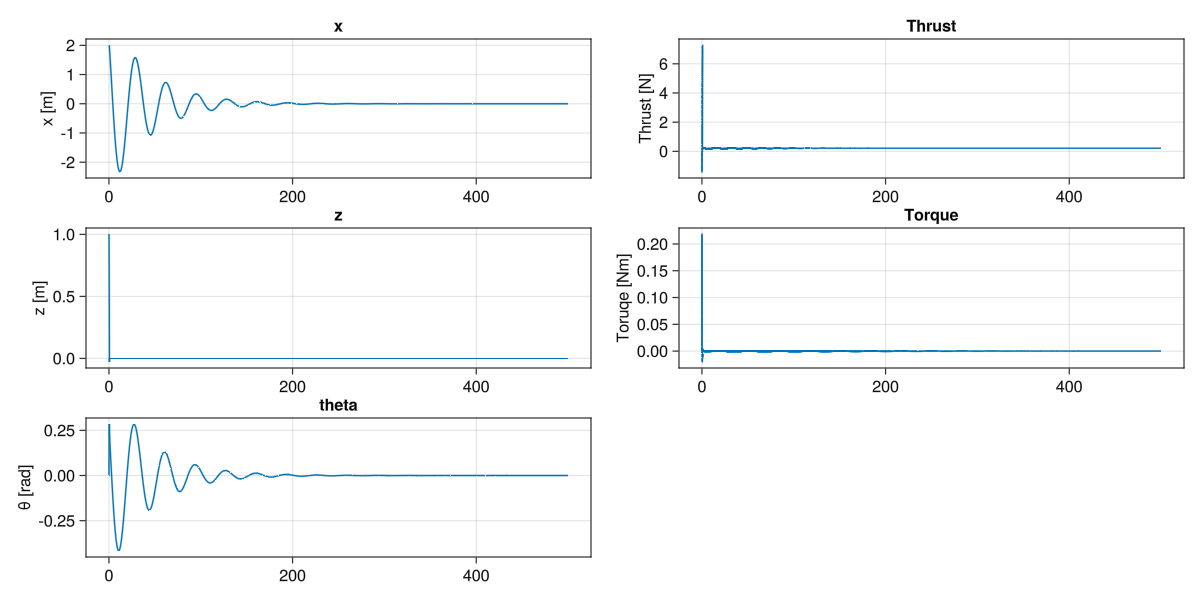

In [18]:
include("utilities.jl")

# initial conditions
@nonamespace u₀ = [
    sys.y => 2.0,
    sys.z => 1.0,
    sys.θ => 0.0,
    sys.yˍt => 0.0,
    sys.zˍt => 0.0,
    sys.θˍt => 0.0,
]

# parameter values
@nonamespace params = [
    sys.l => 0.1,
    sys.I_xx => 0.003 ,
    sys.m => 1.0,
]   

function affect!(integrator)
    # X::Array{Float64} = integrator.u[1:sim_params.nx] # Extract the state 
    
    X::Array{Float64} = integrator.u[3:sim_params.nx+2] # Extract the state 
    # U::Array{Float64} = integrator.u[1:2] # Extract the control signal

    ẏ::Float64 = X[1]
    ż::Float64 = X[2]
    θ̇::Float64 = X[3]
    y::Float64 = X[4]
    z::Float64 = X[5]
    θ::Float64 = X[6]

    # constrain the state
    z_max::Float64 = 10 # m
    ż_max::Float64 = 2 # m/s
    
    if z <= 0
        z = 0
        ż = clamp(ż,0,ż_max)
    end

    # update the state 
    integrator.u[3:sim_params.nx+2] =  [ẏ,ż,θ̇,y,z,θ]
end

condition(u, t, integrator) = integrator.iter > 0

# runs every timestep
cb2 = DiscreteCallback(condition, affect!)

cb_set = CallbackSet(cb1,cb2)


#Pass to solver
tspan = (0.0, 500.0)
prob = ODEProblem(sys, u₀, tspan, params, callback=cb_set,save_everystep=false)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

#plotting
quad_2d_plot(sys, sol)

In [19]:
states(sys)

8-element Vector{Any}:
 f_1(t)
 f_2(t)
 yˍt(t)
 zˍt(t)
 θˍt(t)
 y(t)
 z(t)
 θ(t)